## Fundamentals for Social Data Science in Python - Summative
**Willem Zents**
**MT 2020**

# Instructions

The final essay will allow you to consolidate many of the skills you’ve learned in the course thus far in a single report. This report should be submitted as a Jupyter notebook with working code as well as a description of the work you have done. You should also submit a backup PDF of your notebook.

This essay will have two parts. The combined word total should be 3500 words. The structure of the notebook should look as follows: (with the grade weighting for each section):

* Part 1 setup: (500 words/one Jupyter notebook cell) [10 points]
* Part 1 data analysis in Python (any number of Jupyter notebook cells) [20 points]
* Discussion of Part 1 results (one Jupyter notebook cell/750 words) [10 points]
* Part 2 setup of merging in additional data. [10 points]
* Part 2 data analysis in Python (any number of Jupyter notebook cells) [20 points]
* Discussion of Part 2 results: (750 words/one Jupyter notebook cell) [10 points]
* Limitations of these descriptive analyses (one Jupyter notebook cell) [10 points]

There is an additional 10 points for presentation, which includes both the presentation of the code and the presentation of any tabular or graphic data, consistency of bibliographic sources, and correct use of grammar and syntax. Part 1.

# Part 1

The first part will involve the use of the OxCOVID19 database (https://oxcovid19.eng.ox.ac.uk) , which has an extensive set of data not only including COVID-related data but data on world values, geographic mobility, sociodemographic data, and more. Each table can be linked to others using identifiers as discussed on the database website. You should come up with a research question, justify that research question in a literature review section (of less than 750 words), and then proceed to query the database for the relevant data which you should merge, visualise and make claims about. You do not have to include any statistics on COVID-related data itself should you wish not to. You can instead simply use the additional extensive supplementary data. You should be able to plot the merged data in such a way that it speaks to your research question and report on descriptive statistics where relevant. You are asked not to do any complex multivariate modelling. This question should be primarily descriptive in nature. Example research questions include:

Did areas of the world with different social values (as measured by some question on the World Values Survey) have different proportions of COVID infections in April?
Are people in the UK more mobile on days when the weather was above average? Did this hold during lockdown?
Is air pressure more variable in coastal countries (or coastal regions) or inland countries (or inland regions)? You should interpret the resulting output and summarise it in a report section of not more than 750 words.

It is assumed that the evaluators should be able to reproduce your findings by running the Jupyter notebook themselves.

One important caveat is that this work should not require the installation of any external libraries not featured in class.

## Part 1 - Setup
*500 words*

## Introduction
**Research question: Do governments of countries with higher hospital capacity choose to adopt less stringent measures against COVID-19?**

The worldwide spread of the SARS-CoV-2 virus (coronavirus) has lead to outbreaks of COVID-19 in many countries that have put a strain on national healthcare systems. In some countries, the demand for healthcare services even exceeded the capacity of hospitals, causing, for instance, patients suffering from long-term illness not to be able to receive necessary treatments. While some countries seemed to be well-prepared to meet the excess demand due to COVID, others seemed to be struggling. One important factor in this regard is the availability of hospital and ICU beds \cite{Bauer2020}. \cite{Bauer2020} find that "geographical access to intensive care beds varies significantly across European countries", and that "low ICU accessibility was associated with a higher proportion of COVID-19 deaths to cases". This conclusion is supported by \cite{Sussman2020}, using a larger and more geographically-spread sample of countries. 

In order to reduce transmission and prevent their medical infrastructure from becoming overwhelmed, many countries adopted strict social-distancing measures such as travel restrictions, school closures, or even complete lockdowns \cite{Davies}. Many of these measures are associated with severe social and economic costs \cite{Bonaccorsi2020}. This prompts the question of whether countryies with higher hospital capacity, and therefore a lower risk of seeing its healthcare system overwhelmed by excess capacity, can avoid such social and economic costs by adopting less stringent measures against the spread of COVID. In other words, do governments of countries with higher hospital capacity choose to adopt less stringent measures against COVID-19? Previous literature on the relationship between hospital capacity and government response suggests that in countries with lower hospital capacity, more stringent economic stimulus is adopted \cite{Elgin}, and that countries with higher hospital capacity were slower to adopt COVID-19 restrictions \cite{Sebhatu}. While \cite{Sussman} puts forward the theoretical argument that higher mortality as a result of lower hospital capacity could induce governments to take more stringent measures, the empirical relationship between hospital capacity and stringency of measures remains unclear from the literature and therefore warrants further study.

TODO:
* Explain why WRD_WHO
* Why time focus

## Part 1 - Data Analysis in Python

In [1]:
# Installing psycopg2 - PostgreSQL Database Adapter
# Requires an installation of PostgreSQL on your computer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import json
import requests
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta
from time import sleep

try: 
    import psycopg2
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install psycopg2
    import psycopg2

sns.set_theme(style='whitegrid') # Setting seaborn theme
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True) # Color map for plots

# TODO make sure that this is runnable by an evaluator

In [2]:
# Establishing connection to the OXCOVID-19 Database. Code snippet taken from: https://github.com/covid19db/examples/blob/master/data-loading/data-access-postgresql.ipynb

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [3]:
# Obtaining Data

sql_command = """
SELECT government_response.date, 
government_response.country, 
government_response.countrycode, 
MAX(epidemiology.confirmed) AS confirmed, 
MAX(government_response.stringency_index) AS stringency_index, 
MAX(government_response.economic_support_index) AS economic_support_index,
MAX(CASE WHEN world_bank.indicator_name = 'Hospital beds (per 1,000 people)' THEN world_bank.value END) AS beds,
MAX(CASE WHEN world_bank.indicator_name = 'Population, total' THEN world_bank.value END) AS population,
MAX(CASE WHEN world_bank.indicator_name = 'GDP (current US$)' THEN world_bank.value END) AS gdp,
MAX(CASE WHEN world_bank.indicator_name = 'Hospital beds (per 1,000 people)' THEN world_bank.year END) AS beds_year,
MAX(CASE WHEN world_bank.indicator_name = 'Population, total' THEN world_bank.year END) AS population_year,
MAX(CASE WHEN world_bank.indicator_name = 'GDP (current US$)' THEN world_bank.year END) AS gdp_year
FROM government_response 
INNER JOIN world_bank ON government_response.countrycode = world_bank.countrycode
INNER JOIN epidemiology ON government_response.countrycode = epidemiology.countrycode AND government_response.date = epidemiology.date
WHERE world_bank.indicator_name IN ('Hospital beds (per 1,000 people)', 'Population, total', 'GDP (current US$)') AND epidemiology.source = 'WRD_WHO'
GROUP BY government_response.countrycode, government_response.country, government_response.date
ORDER BY government_response.date DESC
"""

df = pd.read_sql(sql_command, conn)

In [4]:
# Check NAs per column

df.isna().sum()

date                         0
country                      0
countrycode                  0
confirmed                    0
stringency_index          3098
economic_support_index    3588
beds                      2315
population                   0
gdp                        646
beds_year                    0
population_year              0
gdp_year                     0
dtype: int64

Text(0.5, 0.98, 'World Bank Variable Year Distributions')

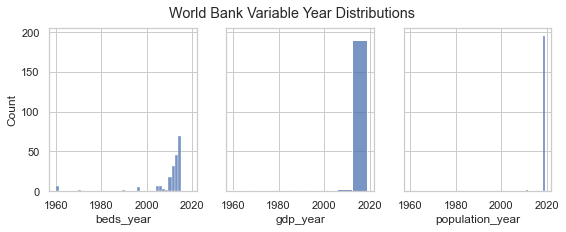

In [5]:
# Data Cleaning

# Inspecting the year element from our World Bank variable 
df_years = pd.DataFrame(df.groupby(['country']).mean())

# Plotting
f, axes = plt.subplots(1,3, figsize=(9, 3), sharex=True, sharey=True)
sns.histplot(x='beds_year', data=df_years, ax=axes[0])
sns.histplot(x='gdp_year', data=df_years, ax=axes[1])
sns.histplot(x='population_year', data=df_years, ax=axes[2])
f.suptitle('World Bank Variable Year Distributions')


Removed 35 countries with outdated values, 161 countries left in the dataset.


Text(0.5, 0.98, 'World Bank Variable Year Distributions')

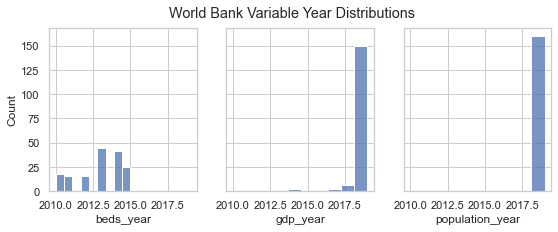

In [6]:
# Data Cleaning

# There are quite some outdated values of the World Bank variable, which could influence our results. Removing values which are >10 years old. 
df_cleaned = df.loc[(df['beds_year']>2009) & (df['population_year']>2009) & (df['gdp_year']>2009)]
diff = (len(df['country'].unique()) - len(df_cleaned['country'].unique()))
left_over = len(df_cleaned['country'].unique())
print(f"Removed {diff} countries with outdated values, {left_over} countries left in the dataset.")

# Plotting to make sure we have done this correctly
df_cleaned_years = pd.DataFrame(df_cleaned.groupby(['country']).mean())

f, axes = plt.subplots(1,3, figsize=(9, 3), sharex=True, sharey=True)
sns.histplot(x='beds_year', data=df_cleaned_years, ax=axes[0])
sns.histplot(x='gdp_year', data=df_cleaned_years, ax=axes[1])
sns.histplot(x='population_year', data=df_cleaned_years, ax=axes[2])
f.suptitle('World Bank Variable Year Distributions')

# After removing countries with outdated values for the world bank variables, we have 161 countries left over. GDP and population data are relatively up-to-date for most countries, while the data for number of beds per 1000 people is a few years old for most countries. We should take this into account when we discuss limitations. 

In [8]:
# Inspecting 'confirmed' variable, since we are interested in measures taken by governments during the pandemic, we will only consider situations where the number of confirmed cases in a country is 10 or more

df_cleaned = df_cleaned.loc[df_cleaned['confirmed']>9] 

In [9]:
# Aggregating the data on country level

df_grouped_mean = df_cleaned.groupby(['country', 'countrycode']).mean()
df_grouped_mean = df_grouped_mean.reset_index(level=['countrycode'])

In [10]:
df_grouped_mean.isna().sum()

countrycode               0
confirmed                 0
stringency_index          2
economic_support_index    2
beds                      0
population                0
gdp                       0
beds_year                 0
population_year           0
gdp_year                  0
dtype: int64

<AxesSubplot:xlabel='loggdppc', ylabel='Count'>

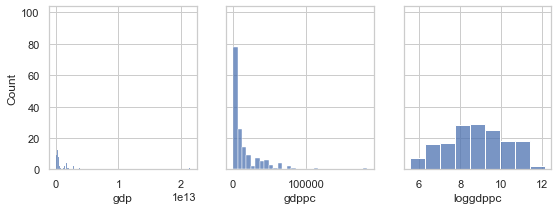

In [11]:
# Constructing per capita measures of GDP

df_grouped_mean['gdppc'] = df_grouped_mean['gdp']/df_grouped_mean['population']
df_grouped_mean['loggdppc'] = np.log(df_grouped_mean['gdppc'])

f, axes = plt.subplots(1,3, figsize=(9, 3), sharex=False, sharey=True)
sns.histplot(x='gdp', data=df_grouped_mean, ax=axes[0])
sns.histplot(x='gdppc', data=df_grouped_mean, ax=axes[1])
sns.histplot(x='loggdppc', data=df_grouped_mean, ax=axes[2])

[Text(0.5, 1.0, 'Correlation Heatmap')]

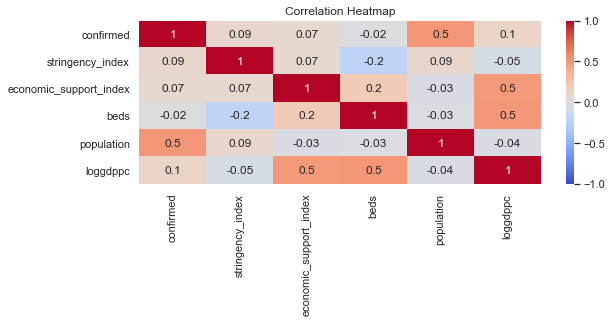

In [15]:
corr = df_grouped_mean[['confirmed', 'stringency_index', 'economic_support_index', 'beds', 'population', 'loggdppc']].corr()
plt.figure(figsize=(9,3))
ax = sns.heatmap(corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
ax.set(title='Correlation Heatmap')

Text(0.5, 0.98, 'Distribution of main variables of interest')

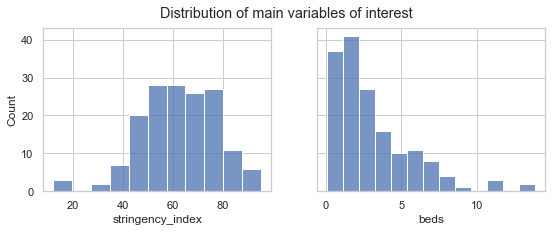

In [17]:
# Initial inspection of the distribution of  variables of interest

f, axes = plt.subplots(1,2, figsize=(9, 3), sharex=False, sharey=True)
sns.histplot(x='stringency_index', data=df_grouped_mean, ax=axes[0])
sns.histplot(x='beds', data=df_grouped_mean, ax=axes[1])
f.suptitle('Distribution of main variables of interest')

[Text(0.5, 0, 'Log of beds per 1000 people'),
 Text(0, 0.5, 'Stringency index'),
 Text(0.5, 1.0, 'Fig. 1 - Simple scatter')]

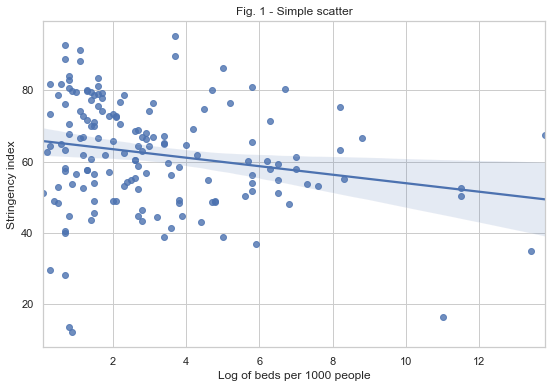

In [18]:
# We begin by looking at a simple scatterplot of the correlation between beds and stringency. It seems that there is a slight negative correlation, but there are also some outliers and we see a lot of variance in stringency especially for countries with a lower number of beds
plt.figure(figsize=(9,6))
ax = sns.regplot(x='beds', y='stringency_index', data=df_grouped_mean)
ax.set(xlabel='Log of beds per 1000 people', ylabel='Stringency index', title='Fig. 1 - Simple scatter')

[Text(0.5, 0, 'Beds per 1000 people'),
 Text(0, 0.5, 'Stringency index'),
 Text(0.5, 1.0, 'Fig. 2 - With GDP and Population')]

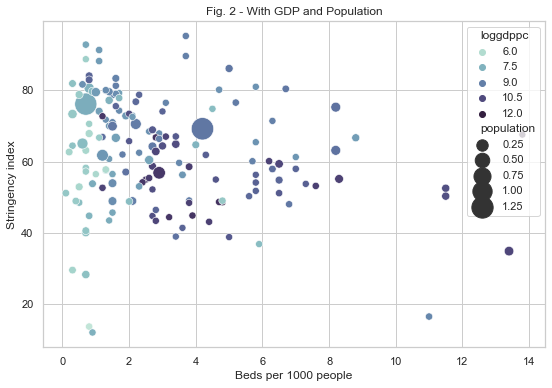

In [19]:
# Let's look at the relationship in more detail by adding two more dimensions to the graph: GDP per capita (as a measure of a country's prosperity) and population size
# It appears that most of the countries with <2 beds per 1000 people are poorer countries, perhaps the high variance in stringency here is caused by confounding variables such as level of democracy that we have not taken into account. 

plt.figure(figsize=(9,6))
ax = sns.scatterplot(x='beds', y='stringency_index', hue='loggdppc', size="population", sizes=(50, 500), palette=cmap, data=df_grouped_mean)
ax.set(xlabel='Beds per 1000 people', ylabel='Stringency index', title='Fig. 2 - With GDP and Population')

In [20]:
# By looking at European countries only we can keep some factors such as governance relatively constant

# Subsetting the data frame to include only european countries
european_countries = ['AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ITA', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE'] # List with countrycodes of European countries
df_grouped_mean_eu = df_grouped_mean.loc[df_grouped_mean['countrycode'].isin(european_countries)]

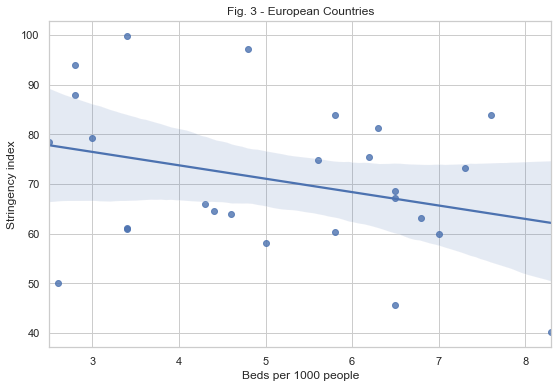

In [21]:
# More complicated plot
plt.figure(figsize=(9,6))
ax = sns.regplot(x='beds', y='economic_support_index', data = df_grouped_mean_eu)
ax.set(xlabel='Beds per 1000 people', ylabel='Stringency index', title='Fig. 3 - European Countries')
plt.show()

## Part 1 - Discussion of results
*750 words*

# Part 2.

Develop a second research question that will require you to build in additional data (in less than 750 words). You will select an API (or direct URL) from the web which will allow you to download said data that you should merge in with the OxCOVID19 data. This second question does not need to be linked thematically to the first. Consider it like a second blog post. . You will first have to justify the choice of external data, your specific choice of API endpoints or URL, time frames or other ranges for this data. You should then report on the merged data through descriptive statistics and plots where appropriate. Data sources could include anything from reddit, Wikipedia, Facebook, Twitter, StackOverflow, or another source not covered in class (as long as it is publicly available either openly or through a free registered account). You can use external libraries (such as praw) in order to collect this data. Please do not submit any private API keys with this data. We suggest that private keys be written in an external file that is read by the notebook just to be safe. You should interpret the resulting output and summarise it in a report section of not more than 750 words.

It is not assumed that the evaluators will be able to reproduce this section with your code since it might involve the use of user-generated API keys or other forms of authentication not available to the evaluators. However, the section should include all relevant code and output other than the keys. You should consider an approach that does not require you to repeatedly request the same data from the API, such as writing it to file and then working on it in a different cell, or from the data you have now stored.

Example research questions for this section:

Do countries with longer Wikipedia pages also have more extensive government responses to COVID?
Comparing two countries, one with a high number of active cases and one with a low number: does the one with active cases have a higher proportion of tweets mentioning COVID in a window of time for Twitter streaming requests.
Which countries are mentioned most often in /r/coronavirus and do they relate to statistics concerning COVID
Examples of non-COVID research questions:

Do countries with longer Wikipedia pages (external) correlate with higher GDP (from the World Bank tables)?
Does a country’s democracy index (e.g., https://en.wikipedia.org/wiki/Democracy_Index) relate to more stable weather?  

## Part 2 - Setup

### Intro
The outbreak of the coronavirus has not only lead to a global public health emergency, but has also caused significant damage to the economy. One particularly immediate and visible effect of the crisis was the plummeting of stock markets around the world. On the 16th of March, the New York Stock Exchange on Wall Street suffered its worst day since 1987, surpassing other moments such as 9/11 and the 2008 Financial Crisis. On the other hand, by late April, stock markets had started to recover and share prices started rising again \citet{Barrero2020}. Furthermore, comparing stock market responses to past outbreaks of infectious diseases, \cite{Barrero2020} find that these past episodes "do not even remotely resemble" the response due to COVID-19. This evidence suggests that the initial shockwave going through financial markets in early March may have been a disproportionate reaction. 

### Problem/puzzle

The fact that the stock market response to COVID-19 in early March was so severe begs the question of which factors influence the severity of this response. In particular, since previous crises such as the 2002-2004 SARS outbreak and the 2008 financial crisis, the global rise of social media and internet connectivity has caused an unprecedented availability of (mis)information about COVID-19 at users' fingertips \cite{Chan2020, Strekalova2020}. Previous research on the effects of the COVID-19 pandemic suggests that (mis)information found on social media has lead to behavioral outcomes such as anxiety, panic-buying, and racism \cite{Ahmad2020, Naeem2020, Depoux2020}. Could it be that panic induced by online information about the coronavirus has contributed to the severity of the stockmarket crash? 

### Significance

### Literature

Within the relatively short timespan since the beginning of the financial recession in March, several articles have explored the response of financial markets to the coronavirus pandemic. \cite{Baker2020} find that the market response cannot be directly attributed simply to epidemiological information about the virus, but rather to non-pharmaceutical interventions by governments, such as social distancing measures. Similarly, \cite{Baig2020} find that implementations of national restrictions lead to increased market volatility, but unlike \citet{Baker2020} they do find that confirmed cases and deaths have a significant effect on market volatility. \citet{Haroon2020} find that panic generated by news outlets is associated with increased stock market volatility. They refer to a seminal work within cognitive psychology by \citet{Griffin1992} who argue that "people focus on the strength or extremeness of the available evidence with insufficient regard for its weight or credence". Finally, \citet{Lycsa2020} find that panic about the coronavirus, as measured by Google search trends, is statistically significant as a predictor of stock price variation. 

### Methods

## Part 2 - Data Analysis in Python

In [34]:
from pytrends.request import TrendReq
import yfinance as yf

In [ ]:
key = 'be75bbfd-b802-48bc-b2c6-3dcd9b1b80e5'
params = {
    'from-date': "2020-01-01",
    'to-date': "2020-04-01",
    'order-by': "newest",
    'show-fields': 'webTitle',
    'page-size': 200, # Max page size
    'api-key': key
}

def guardian_download(key, params): # Adapted from https://gist.github.com/dannguyen/c9cb220093ee4c12b840

    MY_API_KEY = key
    API_ENDPOINT = 'http://content.guardianapis.com/search?q=coronavirus%20OR%20covid'
    my_params = params

    start_date = date(2020, 1, 1)
    end_date = date(2020, 4, 30)
    dayrange = range((end_date - start_date).days + 1)

    df = pd.DataFrame()

    for day in dayrange:
        dt = start_date + timedelta(days=day)
        datestr = dt.strftime('%Y-%m-%d')

        print("Downloading", datestr)
        all_results = []
        my_params['from-date'] = datestr
        my_params['to-date'] = datestr
        current_page = 1
        total_pages = 1
        while current_page <= total_pages:
            print("...page", current_page)
            my_params['page'] = current_page
            response = requests.get(API_ENDPOINT, my_params)
            data = response.json()
            temp = pd.json_normalize(data['response']['results'])
            df = df.append(temp, ignore_index=True)

            # if there is more than one page
            current_page += 1
            total_pages = data['response']['pages']

        sleep(0.5)  # Reduce load

    return df

guardian_df = guardian_download(key, params)

guardian_df.index = pd.to_datetime(guardian_df['webPublicationDate'])
guardian_df = guardian_df.resample('d').count()


In [95]:
# Google data

pytrends = TrendReq(hl='GB', tz=0)

pytrends.build_payload(kw_list=['coronavirus'], timeframe='2020-01-01 2020-04-30', geo='GB')
google_df = pytrends.interest_over_time()

In [76]:
# Finance data

FTSE = yf.Ticker("^FTSE")
ftse_df = FTSE.history(start="2020-01-01", end="2020-04-30")
ftse_df['Returns'] = ftse_df['Close'] - ftse_df['Close'].shift(-1)

In [73]:
sql_command = """
SELECT government_response.date, 
epidemiology.confirmed, 
government_response.stringency_index 
FROM government_response 
INNER JOIN epidemiology ON government_response.countrycode = epidemiology.countrycode AND government_response.date = epidemiology.date
WHERE epidemiology.source = 'WRD_WHO' AND government_response.countrycode = 'GBR' AND government_response.date BETWEEN '2020/01/01' AND '2020/04/30'
ORDER BY government_response.date DESC
"""

covid_df = pd.read_sql(sql_command, conn)
covid_df['New'] = covid_df['confirmed'] - covid_df['confirmed'].shift(-1)
covid_df.index = pd.to_datetime(covid_df['date'])

In [100]:
# guardian_df.index = guardian_df.index.tz_convert('UTC')
# covid_df.index = covid_df.index.tz_convert('UTC')
# google_df.index = google_df.index.tz_localize('UTC')
# ftse_df.index = ftse_df.index.tz_localize('UTC')

df_total = covid_df.merge(guardian_df['webTitle'], left_index=True, right_index=True).merge(google_df, left_index=True, right_index=True).merge(ftse_df, left_index=True, right_index=True)

## Part 2 - Discussion of Results
*750 words*

Finally, please write a reflective conclusion (of not more than 500 words) that discusses the limitations of the data in relation to your claims. You are also encouraged to build in any concerns about insights arising from this data, ethical issues with the analysis, and potential future avenues for analysis based on your work.

This work, while in a report style, should be referenced like any scholarly work. Please include a cell at the bottom of your notebook which includes all the references.

We request that you submit this summative as both a working Jupyter notebook (*.ipynb file) and as a PDF file that includes all of your output. This is because the evaluators may run your code and might still want to check this with the output that you have submitted. This pdf can either be generated from JupyterLab itself if you have the appropriate LaTeX modules installed or simply by going to ‘print’ for that browser window and print to PDF. 

## Limitations
*One cell*

# Submission Instructions 

The assignment must be submitted electronically via the Assignment Submission WebLearn Site before midday on Monday 7th December (Week 9 Michaelmas Term).

If anything goes wrong with your submission, email msc@oii.ox.ac.uk immediately. In cases where a technical fault that is later determined to be a fault of the WebLearn system (and not a fault of your computer) prevents your submitting the assessment on time, having a time stamped email message will help the Proctors determine if your assessment will be accepted. Please note that you should not wait until the last minute to submit materials since WebLearn can run slowly at peak submission times and this is not considered a technical fault.

Full instructions on using WebLearn for electronic submissions can be found on Canvas.

Candidate Number and Cover Sheet: Remember to use the OII coversheet, stating clearly your candidate number, your course, assignment, title and word count. Your work should be identified ONLY by your candidate number (which can be found by visiting the online Student Self-Service facility).

Remember we are required under regulations to accept your FIRST submission so please make sure you are uploading the correct file.

### Ideas
* Do countries with lower hospital capacity impose stricter measures?
    * It would make sense that countries which have less capacity in their hospitals run a higher risk of getting overwhelmed by a rise of COVID cases, therefore they have less room to take risks by having looser restrictions.

* Bauer et al. find that "geographical access to intensive care beds varies significantly across European countries and low ICU accessibility was associated with a higher proportion of COVID-19 deaths to cases (CFR)". 

* Davies et al.: "These studies have broadly suggested that moderate measures could reduce epidemic size, but more intensive measures would be required to ensure health system capacity was not surpassed."

* Davies et al. " Intensive interventions with lockdown periods would need to be in place for a large proportion of the coming year to prevent health-care demand exceeding availability."

* Sebhatu et al: Countries with higher care capacity were slower to adopt COVID-19 restrictions.

* Sussman: "A smaller supply of hospital beds leads to higher mortality rates that induce governments to take more stringent closure measures that have greater economic costs. Higher mortality could also affect consumer confidence, bring about panic-driven decisions that also affect the economy adversely."

* Elgin: "This result implies that countries where the number of beds per capita is lower, more stringent economic stimulus is adopted."
